# IBM Advanced Data Science Capstone 
## Recognition of Handwritten in Keras
## By Yuliia Hetman

## Overview

Offline Handwritten Text Recognition (HTR) systems transcribe text contained in scanned images into digital text. Off-line handwriting recognition involves the automatic conversion of text in an image into letter codes which are usable within computer and text-processing applications. The data obtained by this form is regarded as a static representation of handwriting. Off-line handwriting recognition is comparatively difficult, as different people have different handwriting styles.

In Deep Learning Convolutional Neural Networks are most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks, based on their shared-weights architecture and translation invariance characteristics. In this notebook I am going to build a Model consists of several Neural Networks which is going to be trained on images of names and surnames, the dataset original resource is https://appen.com.

### Dataset Overview

This dataset consists of more than four hundred thousand handwritten names collected through charity projects to support disadvantaged children around the world.

Character Recognition utilizes image processing technologies to convert characters on scanned documents into digital forms. It typically performs well in machine-printed fonts. However, it still poses difficult challenges for machines to recognize handwritten characters, because of the huge variation in individual writing styles.

There are 206,799 first names and 207,024 surnames in total. The data was divided into a training set (331,059), testing set (41,382), and validation set (41,382) respectively.

### Dataset Content

The input data here are hundreds of thousands of images of handwritten names. In the Data, you’ll find the transcribed images broken up into test, training, and validation sets.

Image Lable follow the following naming format enabling you to extend the data set with your own data.

Off-line handwriting recognition involves the automatic conversion of text in an image into letter codes which are usable within computer and text-processing applications. The data obtained by this form is regarded as a static representation of handwriting. Off-line handwriting recognition is comparatively difficult, as different people have different handwriting styles.

In Deep Learning Convolutional Neural Networks are most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks, based on their shared-weights architecture and translation invariance characteristics. In this notebook I am going to build a Model consists of several Neural Networks which is going to be trained on images of names and surnames, the dataset original resource is https://appen.com.
 
The images in the dataset are already divided into three folders named according to the modeling step of their usage:
1. test_v2
2. train_v2
3. validation_v2

Also, there a .csv file for each folder which contains a list of filenames with the corresponding transcribed handwritten name.

|    FILENAME   | IDENTITY |
|:-------------:|:--------:|
| TEST_0001.jpg |   KEVIN  |


## Step 1: Data Exploration

So, the most important steps are:
- identify quality issues (e.g. missing values, wrong measurements, …)
- assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)
- get an idea on the value distribution of data using statistical measures and visualizations


In [1]:
#!pip install kaggle

### Download and extract the dataset 

In [2]:
## Downloading dataset
#!set -e
#!mkdir -p dataset
#!kaggle datasets download --force -d landlord/handwriting-recognition

In [3]:
#!mv handwriting-recognition.zip ./dataset/
#!cd dataset

In [4]:
#!unzip handwriting-recognition.zip

In [5]:
#!ls dataset/

### Importing all we need 

In [6]:
import os
from os import listdir
from time import time
import sys
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from colorama import Fore, Back, Style
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession 
#from pyspark.sql.types import *
#from pyspark.sql import Row
#from pyspark.sql.functions import *

import cv2
#import tensorflow as tf
#from keras import backend as K
#from keras.models import Model
#rom keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
#from keras.optimizers import Adam
#sns.set()

In [7]:
#!pip install opencv-python

### Reading comma-separated values files 

In [8]:
IMAGE_PATH = "./dataset/"
TRAIN_PATH = IMAGE_PATH + 'train_v2/train/'
TEST_PATH = IMAGE_PATH + 'test_v2/test/'
VALID_PATH =IMAGE_PATH + 'validation_v2/validation/'
list(os.listdir(IMAGE_PATH))

['written_name_train_v2.csv',
 'test_v2',
 'train_v2',
 'validation_v2',
 'written_name_test_v2.csv',
 'written_name_validation_v2.csv']

In [9]:
train_labels = pd.read_csv(IMAGE_PATH + 'written_name_train_v2.csv')
test_labels = pd.read_csv(IMAGE_PATH +'written_name_test_v2.csv')
validation_labels = pd.read_csv(IMAGE_PATH + 'written_name_validation_v2.csv')

In [10]:
LABELS = [train_labels, test_labels, validation_labels]
SETS = ['TRAINING SET', 'TESTING SET', 'VALIDATION SET']

### Simple analysis of the data

In [11]:
for i in range(len(LABELS)):
    print(Fore.BLUE + SETS[i],'SHAPE:',Style.RESET_ALL,LABELS[i].shape)
train_labels.head(5)

TRAINING SET SHAPE:  (330961, 2)
TESTING SET SHAPE:  (41370, 2)
VALIDATION SET SHAPE:  (41370, 2)


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [12]:
## check similar names/surnames 
for i in range(len(LABELS)):
    print(Fore.BLUE + SETS[i], ":\n",Style.RESET_ALL,LABELS[i].groupby(['IDENTITY']).count()['FILENAME'].to_frame().head())

TRAINING SET :
               FILENAME
IDENTITY             
'A'OPES             1
'LE BASTARD         1
-                   8
--                  2
-------             2
TESTING SET :
            FILENAME
IDENTITY          
-                1
A                5
AABEL            1
AADAOU           1
AALLIYAN         1
VALIDATION SET :
                  FILENAME
IDENTITY                
A                      4
A LVYNE                1
AA                     1
AALIAH-ALISSON         1
AALIYAH                2


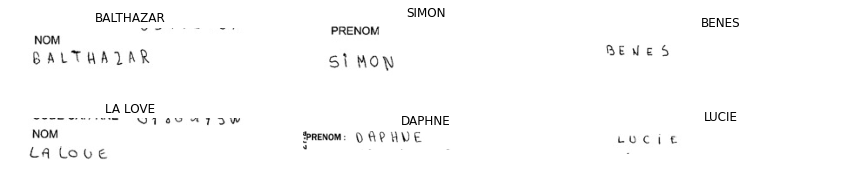

In [13]:
## Plotting some samples

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_file = TRAIN_PATH + train_labels.loc[i, 'FILENAME']
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_labels.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Data cleaning

In [14]:
# Drop all the missing values as Coldplay drops sounds
for i in range(len(LABELS)):
    print(Fore.BLUE + SETS[i],":\n",Style.RESET_ALL,LABELS[i].isna().sum(),'\n')
    LABELS[i].dropna(axis=0, inplace=True)

TRAINING SET :
  FILENAME      0
IDENTITY    565
dtype: int64 

TESTING SET :
  FILENAME     0
IDENTITY    70
dtype: int64 

VALIDATION SET :
  FILENAME     0
IDENTITY    78
dtype: int64 



Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

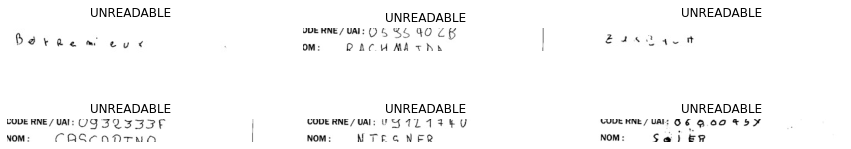

In [15]:
unreadable_samples = train_labels[train_labels['IDENTITY'] == 'UNREADABLE']
unreadable_samples.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = TRAIN_PATH + unreadable_samples.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable_samples.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [16]:
for table in LABELS:
    table = table[table['IDENTITY'] != 'UNREADABLE']

for each in (train_labels, test_labels, validation_labels):
    each['IDENTITY'] = each['IDENTITY'].str.upper()
    each.reset_index(inplace = True, drop = True)
    
for i in range(3):
    print(Fore.BLUE+SETS[i],Style.RESET_ALL)
    print(LABELS[i].info())
    print('-'*40+'\n')


TRAINING SET 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330396 entries, 0 to 330395
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330396 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None
----------------------------------------

TESTING SET 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41300 entries, 0 to 41299
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41300 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 645.4+ KB
None
----------------------------------------

VALIDATION SET 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41292 entries, 0 to 41291
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41292 non-null  object
 1   IDENTITY  41292 non-null  ob

### Starting PySpark session for image processing

In [17]:
#!pip install pyspark==2.4.5

In [18]:
sc = SparkContext.getOrCreate(conf=SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

In [19]:
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import lit

### Image reading and preprocessing

In [20]:
def image_reading(df, size):
    x_ = []
    for each in range(len(df)):
        image_path = TRAIN_PATH + df.loc[each, "FILENAME"]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = preprocessing(image)
        x_.append(image)
    return x_

In [21]:
def preprocessing(image):
    (height, width) = image.shape
    blanket = np.ones([64, 256]) * 255
    if width > 256:
        image = image[:, :256]
    if height > 64:
        image = image[:64, :]
    blanket[:height, :width] = image
    image = cv2.rotate(blanket, cv2.ROTATE_90_CLOCKWISE)
    return (image / 255)

In [ ]:
size = 20
x_train = image_reading(train_labels,size)
x_validation = image_reading(validation_labels,size/2)
x_test = image_reading(test_labels, size/4)

In [ ]:




#train_df = spark.read.format("image").load(TRAIN_PATH)

#test_df = spark.read.format("image").load(TEST_PATH)

#validation_df = spark.read.format("image").load(VALID_PATH)

In [ ]:
#display(train_df)

In [ ]:
#train_df.printSchema()

In [ ]:
#train_df.toPandas()